<a href="https://colab.research.google.com/github/mkorlyakova/Detector-from-video/blob/master/Detector_%2B_SiamNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import and Function definition:

DeepLearning framework:
tensorflow 2.x
Keras 2.3
tensorflow_hub

Image processing framework:
PIL
cv2

Utilit:

google.colab




In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub
# Keras modules.
from tensorflow.python.keras.layers import Dense,Input, Conv2D, Flatten, Dropout, MaxPooling2D,Conv1D,Subtract, BatchNormalization 
from tensorflow.python.keras.models import Model

from tensorflow.python.keras.layers import Lambda, Conv1D, Reshape
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def abs_layer(x):
  return tf.abs(x)


# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


Mount Google Drive and Read directori path to Image for **detect**

Подключаю диск и записываю директорию для чтения файлов на трекинг

In [3]:
from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/My Drive/Moutain_Bike/mountain-bike/'  #change dir to your project folder  



Mounted at /content/drive


Read filename List (for detect).

Чтение имен кадров для трекинга в базе 

In [4]:
import os, fnmatch
listOfFiles = os.listdir(root_path)
pattern = '*.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]


array('/content/drive/My Drive/Moutain_Bike/mountain-bike/datasets_36409_55264_TrackingDataset_Kwon_VTD_basketball_frame_0001.jpg',
      dtype='<U122')

# **Формируем нейронную сеть - сиамского типа**

Create SiamNet:



In [6]:
def model_classif_fin(level=2, n_dense = 100):
  # функция для обработки данных в плече сиамской сети
  x_inp =Input(shape=(32,32,3))
  # собираю сетку
  x=BatchNormalization()(x_inp)
  x=Conv2D(32, (5, 5) , activation='relu', padding='same')(x)
  x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
  x=MaxPooling2D()(x)
  # будет не менее одного стека сверток+пулинг
  for k in range(level):
    x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
    x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
    x=MaxPooling2D()(x)
  x=Flatten()(x)
  # можно сделать второй слой полносвязки, но это сильно утяжелит сеть
  if n_dense>0:
    x_1=Dense(n_dense, activation = 'relu')(x)
  else:
    x_1=x

  siam_classifier =Model(x_inp,x_1)
  siam_classifier.compile(optimizer='Adam', loss=['categorical_crossentropy'],metrics=['accuracy'])
  return  siam_classifier

def SiamNet_create(siam_weigth ='/content/siam_net_weight.h5' ):
  # имя файла весов сети
  classifier1  = model_classif_fin(level=1, n_dense = 256)
  classifier2  = model_classif_fin(level=1, n_dense = 256)

  flat1 = (classifier1.layers[-1].output)
  flat2 = (classifier2.layers[-1].output)

  flat_1=Subtract()([flat1,flat2])
  flat_ = Lambda(abs_layer)(flat_1)
  class1 = Dense(256, activation='relu')(flat_)
  output = Dense(1, activation='sigmoid')(class1)

  model_ = Model([classifier2.input,classifier1.input], output)
  
  model_.compile(optimizer='SGD',loss=['binary_crossentropy'],metrics=['accuracy'])

  model_.load_weights(siam_weigth)
  #print(model_.layers[-1])
  return model_

In [7]:
model_ = SiamNet_create(siam_weigth ='/content/siam_net_weight.h5' )

## **Import detection result**

## **Импорт и обработка результатов детектирования**

In [8]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """отрисовка одной рамки. из примера tensorflow"""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)


  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # 
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # 
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=30, min_score=0.01):
  """отрисовка рамок. из примера tensorflow"""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Загрузка детектора

In [9]:
#module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
module_handle ="https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Формируем тензор

In [10]:
def load_img(path):
  # Делаем изображение на вход сети
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

Выполняем детектор

In [11]:

def run_detector(detector, path, numb=100, verbose = 1):
  """ из примера tensorflow"""
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  
  result = detector(converted_img)
  
  end_time = time.time( )
  print("*detect imgmag time : ", end_time-start_time ,'s.')
  result = {key:value.numpy() for key,value in result.items()} 

  if verbose==1:
    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=numb)

    display_image(image_with_boxes)
  return result

Возвращаем рамки для объектов

In [12]:
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=100, min_score=0.1, class_ = b'Person',frame_n =  0):
  """получить рамку из результатов детектора. из примера tensorflow"""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  im_coord=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if (scores[i] >= min_score) & (class_names[i] == class_):
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(cv.resize(imf.copy(),(32,32))/225)  
      im_coord.append([[boxes[i], frame_n ]]) 
  return im_array, im_coord

In [13]:
def get_boxes(image, boxes, class_names, scores, max_boxes=100, min_score=0.1, class_ = b'Person', frame_n =  0):
  """строим картинку с рамками. из примера tensorflow"""
  image_pil = np.array(image)
  
  imf, im_coord = get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1, class_ = class_, frame_n = frame_n )
  #print('im_list :',len(imf),'  im_coord: ',len(im_coord))   
  return imf,im_coord 

Проверяем детектор

In [14]:
#/content/drive/My Drive/Moutain_Bike/mountain-bike
List_name[0]

array('/content/drive/My Drive/Moutain_Bike/mountain-bike/datasets_36409_55264_TrackingDataset_Kwon_VTD_basketball_frame_0001.jpg',
      dtype='<U122')

*detect imgmag time :  11.43782925605774 s.


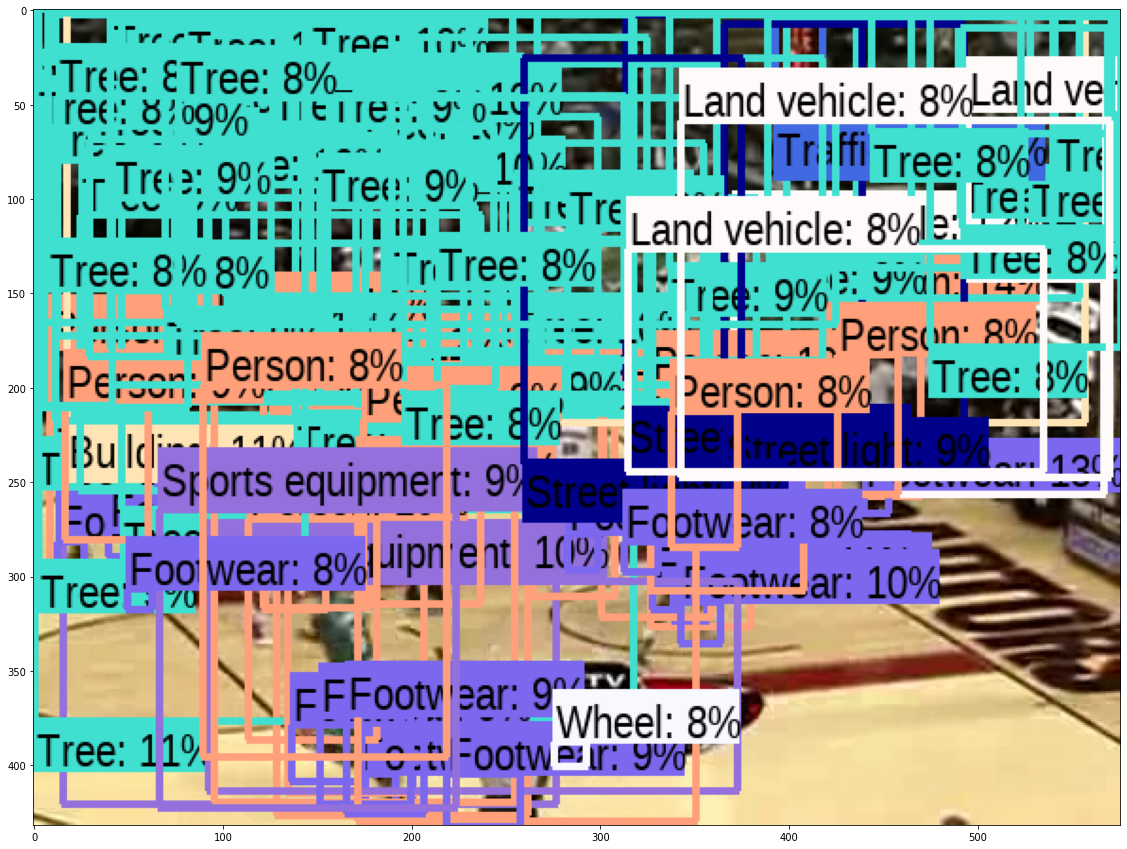

In [15]:
result = run_detector(detector, List_name[0])

In [16]:
import cv2 as cv


# **Запуск трекинга**

1) читаем нулевой кадр и заполняем List_coord список координат объектов, где для каждого пишем : [[ymin, xmin, ymax, xmax], номер кадра = 0]
2) одновременно пишем список изображений от детектора imlist2 - и нормализуем его по уровняям [0,1] и размеру (32х32х3)

3) для следующих кадров повторяем:
  
  3.1) List_coord_old =List_coord
       imlist1=imlist2
  
  3.2) заполняем List_coord список координат объектов, где для каждого пишем : [[ymin, xmin, ymax, xmax], номер кадра = m]
  
  3.3) одновременно пишем список изображений от детектора imlist2 - и нормализуем его по уровняям [0,1] и размеру (32х32х3)
  
  3.4) делаем I_1,I_2 сетку примеров - все со всеми
  
  3.5) подаем примеры в сиамскую сеть predict()
  
  3.6) отсеиваемм примеры с порогом распознавания менее porog
  
  3.7) добавляем хорошие треки к списку найденых под кадров      

In [17]:

import warnings
warnings.simplefilter('ignore')

In [105]:
CLASS_ID = b'Person'
N=0 # число объектов для отображения пар
porog=0.9 #  порог реакции Сиамской сети (подобрали на предшествующих шагах)

# инициализация списка координат
result2 = run_detector(detector, List_name[0],numb=1000, verbose = 0) # обрабатываем детектором 0-й кадр
#  формируем список выбраных детектором областей кадра
img2 = load_img(List_name[0])
imlist2,List_coord =get_boxes(img2 , result2["detection_boxes"],
      result2["detection_class_entities"], result2["detection_scores"], max_boxes=1000, class_ = CLASS_ID, frame_n =  0)

# инициализируем список картинок для Сиамской сети
I1=[]
I2 = imlist2.copy()  
# выбираем только объекты нужного класса "Person" и добавляем их в список для поиска новых пар (список I2)

#  делаем поиск текущего объекта в списке старых 
for m in range(1,len(List_name)):
  #plt.figure(figsize=(7,30))
  List_coord_old=List_coord.copy()
  
  List_coord=[]
  # переносим содержимое списка из 2 в 1 (кадр предществующего момента стал прошлым)
  start_time = time.time()
  result1 = result2.copy()
  img1 = img2.numpy()
  imlist1=imlist2.copy()
  # строим новое детектирование для текущего кадра 
  result2 = run_detector(detector, List_name[m], numb=1000, verbose = 0)
  img2 = load_img(List_name[m])

  # обновим список координат объектов  

  imlist2,List_coord=get_boxes(img2, result2["detection_boxes"], result2["detection_class_entities"], result2["detection_scores"],max_boxes=1000, class_ = CLASS_ID, frame_n =  m)
  list_re=List_coord.copy()
  # обновим список хранимых изображений объектов (прошлый кадр стал I1)
  I1=I2.copy()
  I2 =[]

  # заполняем кадр новыми детектированиями
  # выбираем только объекты нужного класса "Person" и добавляем их в список для поиска новых пар (список I2)

  I2 = imlist2.copy()  


  # создаем входной список для работы сиамской сети (строим пары из I1 , I2)
  I_1=[]
  I_2=[]
  for i in I1:
    for j in I2:
      I_1.append(i)
      I_2.append(j)
  I_1=np.array(I_1)
  I_2=np.array(I_2)    
  p=model_.predict([I_1,I_2])  
  
  p_res=p.reshape((len(I1),len(I2)))
  # каждому объекту из I2 ищем соответствие в I1 и 
  # по максимальному соответствию берем номер объекта для записи в трек 
  ind_p= np.argmax(p_res,axis=1)
  # Визуализация
  #print(List_coord)
  List_d = List_coord.copy()
  for k in range(len(List_coord_old)):
    if p_res[k,ind_p[k]]>porog:
        list_new = List_coord_old[k]+List_d[ind_p[k]]
        List_coord[ind_p[k]]=list_new.copy()
        


  end_time = time.time()
  #plt.show()
  print('seaching time ',end_time-start_time,'s.')
List_coord_old=List_coord.copy()

*detect imgmag time :  0.24587011337280273 s.
*detect imgmag time :  0.2297499179840088 s.
seaching time  0.30350375175476074 s.
*detect imgmag time :  0.22855615615844727 s.
seaching time  0.3032529354095459 s.
*detect imgmag time :  0.245650053024292 s.
seaching time  0.3213684558868408 s.
*detect imgmag time :  0.22737717628479004 s.
seaching time  0.28727293014526367 s.
*detect imgmag time :  0.22589826583862305 s.
seaching time  0.2933218479156494 s.
*detect imgmag time :  0.2476334571838379 s.
seaching time  0.3182096481323242 s.


выведем длину трекинга по последней List_coord

In [106]:
for i in range(len(List_coord)):
  print(len(List_coord[i]))

2
1
1
3
0
3
0
1
1
1
1
0
0
0
2


Выведем на экран трекинг объекта mm

трек  0  в составе  4  кадров.


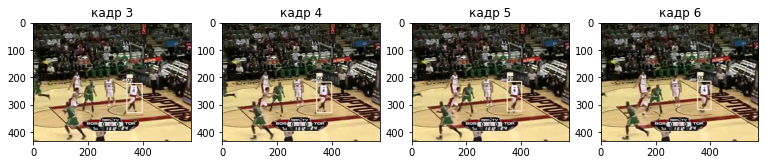

трек  1  в составе  3  кадров.


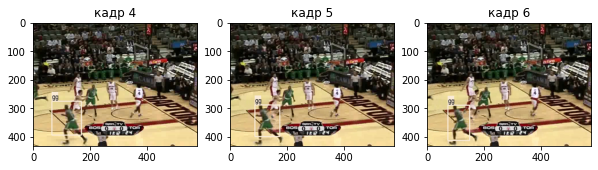

трек  2  в составе  2  кадров.


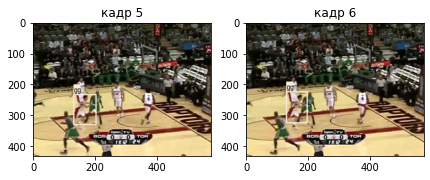

трек  3  в составе  7  кадров.


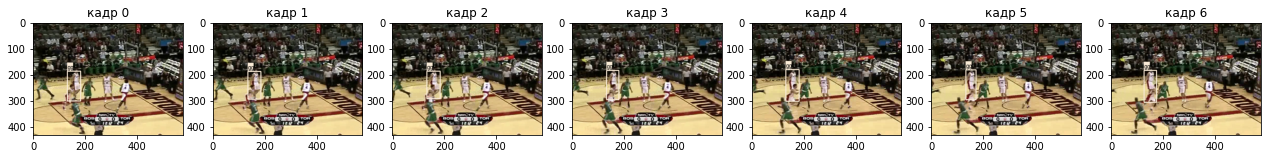

трек  4  в составе  1  кадров.


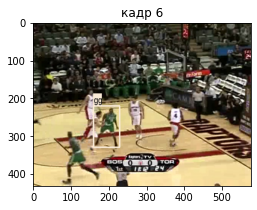

трек  5  в составе  7  кадров.


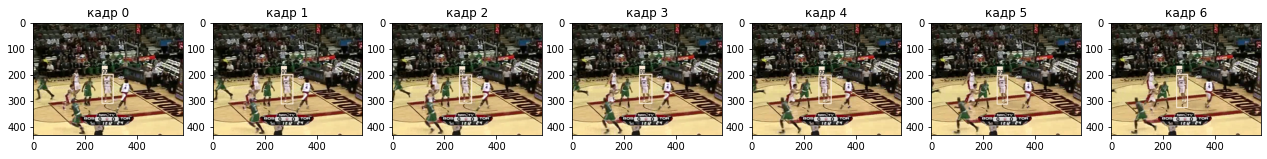

трек  6  в составе  1  кадров.


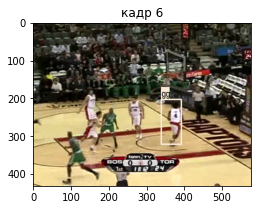

трек  7  в составе  3  кадров.


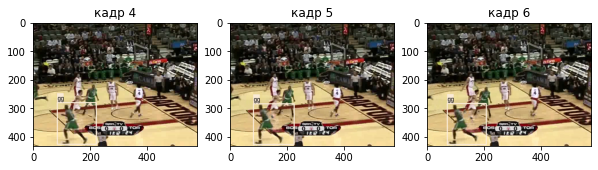

трек  8  в составе  2  кадров.


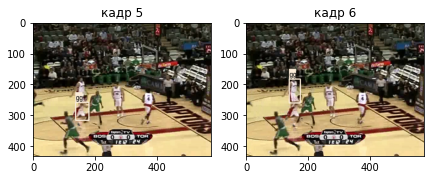

трек  9  в составе  2  кадров.


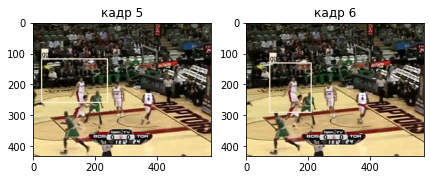

трек  10  в составе  2  кадров.


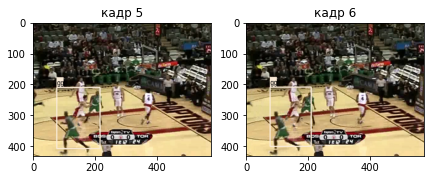

трек  11  в составе  1  кадров.


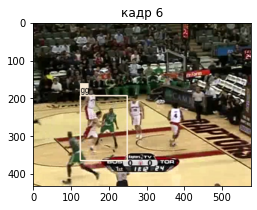

трек  12  в составе  1  кадров.


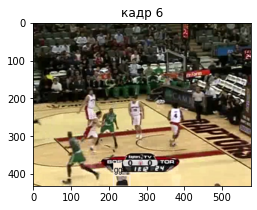

трек  13  в составе  1  кадров.


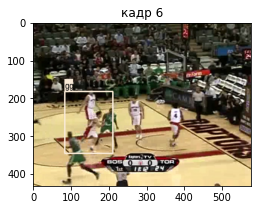

трек  14  в составе  4  кадров.


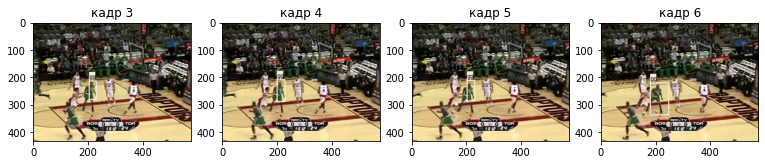

In [111]:
colors = list(ImageColor.colormap.values())

try:
  font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

for mm in range(len(List_coord)):
  nm = (len(List_coord[mm]))
  print('трек ', mm, ' в составе ', nm, ' кадров.')
  plt.figure(figsize=(nm*3+1,3))
  for i in range(len(List_coord[mm]) ):
    #print(List_coord[mm][i*2],List_coord[mm][i*2+1])
    m=List_coord[mm][i][1]
    img1 = load_img(List_name[m])
    img = img1.numpy()  
    h,w,c=img.shape
    ymin, xmin, ymax, xmax= (List_coord[mm][i][0])
    #m = (List_coord[mm][i*2+1])

    #print([ymin, xmin, ymax, xmax ], [''], [100])
    plt.subplot(1,nm,i+1)
    plt.title('кадр '+str( m ))
    image_pil = Image.fromarray(np.uint8(img)).convert("RGB")
    draw_bounding_box_on_image(image_pil,ymin, xmin, ymax,xmax, colors[1],font, display_str_list=['gg'])
    np.copyto(img, np.array(image_pil))
    plt.imshow(img)
  plt.show()